In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chardet
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalMaxPool1D, Conv1D
from keras.layers import Embedding
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
#
from keras import utils

In [2]:
!pip install -U -q PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
fileDownloaded = drive.CreateFile({'id':'1WPo4J9wi0bIXl2I5da_UYc1UqV8q_iRw'})
fileDownloaded.GetContentFile('data_init.csv')

In [6]:
with open('data_init.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1254',
 'confidence': 0.4445340489203496,
 'language': 'Turkish'}

In [7]:
df = pd.read_csv('data_init.csv',encoding='iso-8859-1',error_bad_lines=False, index_col = False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572928 entries, 0 to 572927
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ProductId                  572928 non-null  int64  
 1   Manufacturer Account Name  572928 non-null  object 
 2   Brand/Label                572928 non-null  object 
 3   IDEA''s Public ID          572928 non-null  int64  
 4   UPC Number                 525059 non-null  float64
 5   EAN Number                 115523 non-null  float64
 6   Catalog Number             572928 non-null  object 
 7   Invoice Description        572928 non-null  object 
 8   Catalog Description        387640 non-null  object 
 9   UNSPSC code                567206 non-null  float64
 10  IGCC code                  385015 non-null  float64
 11  CMD Category               567195 non-null  object 
 12  GTIN                       390194 non-null  float64
dtypes: float64(5), int64(2), obje

In [9]:
cmd_count = df['CMD Category'].value_counts()
df['CMD_COUNT'] = df['CMD Category'].map(df['CMD Category'].value_counts())
cmd_count
threthold = 1000
others_count = cmd_count[cmd_count <=threthold ].count()
others_sum = cmd_count[cmd_count <= threthold].sum()
total = cmd_count.sum()
other_pct = others_sum/total*100
print("When threthold is", threthold, ", the total number of CMD categories moved to'other' categories is", others_count)
print("The total products in 'other' category is", others_sum)
print("Percentage of products that grouped in the 'other' category is", f'{other_pct:.2f}',"%")

When threthold is 1000 , the total number of CMD categories moved to'other' categories is 2429
The total products in 'other' category is 159837
Percentage of products that grouped in the 'other' category is 28.18 %


In [10]:
df.loc[df["CMD_COUNT"] <= 1000, "CMD Category"] = "Other"

In [11]:
cmd_count = df['CMD Category'].value_counts()
cmd_count

Other                                                  159837
Cable tray fitting and accessories                      21095
Circuit breakers                                        17929
Molded case circuit breakers                            17075
Electrical equipment maintenance and repair service     13541
                                                        ...  
Circular connectors                                      1041
Incandescent lamps                                       1034
Cartridge fuses                                          1029
Remote lighting fixture                                  1024
Midget fuses                                             1016
Name: CMD Category, Length: 130, dtype: int64

In [12]:
df = df[df['CMD Category']!= 'Other']

In [13]:
sentences = df['Invoice Description']
y = df['CMD Category']
sentences_train, X_test, sentences_y, test_y = train_test_split(sentences, y, test_size=0.1, random_state=42)
X_train, X_val, train_y, val_y = train_test_split(sentences_train, sentences_y, test_size=0.1, random_state=42)

In [14]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(train_y.shape)
print(val_y.shape)
print(test_y.shape)

(334602,)
(37179,)
(41310,)
(334602,)
(37179,)
(41310,)


In [15]:
tokenize = Tokenizer(num_words=1000)
tokenize.fit_on_texts(sentences_train)


In [16]:
X_train = tokenize.texts_to_sequences(X_train)
X_val = tokenize.texts_to_sequences(X_val)
X_test = tokenize.texts_to_sequences(X_test)

In [17]:
vocab_size = len(tokenize.word_index) + 1

In [18]:
maxlen = 100

X_train = keras.utils.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = keras.utils.pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = keras.utils.pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])


[600 295  24  49  78   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [19]:
encoder = LabelEncoder()
encoder.fit(train_y)
y_train = encoder.transform(train_y)
y_val = encoder.transform(val_y)
y_test = encoder.transform(test_y)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_val = utils.to_categorical(y_val, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
embedding_dim = 16

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(130, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           1014896   
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 32)                51232     
                                                                 
 dense_1 (Dense)             (None, 130)               4290      
                                                                 
Total params: 1,070,418
Trainable params: 1,070,418
Non-trainable params: 0
_________________________________________________________________


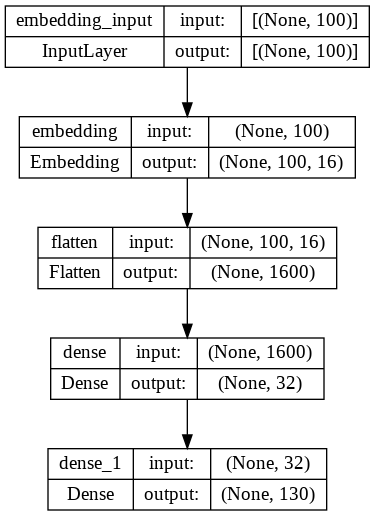

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [23]:
history1 = model.fit(X_train, y_train,
                    batch_size= 32,
                    epochs=25,
                    validation_data=(X_val, y_val))

Epoch 1/25
10457/10457 [==============================] - 52s 5ms/step - loss: 2.2257 - accuracy: 0.4732 - f1_m: 0.4583 - precision_m: 0.8096 - recall_m: 0.3326 - val_loss: 1.7212 - val_accuracy: 0.5757 - val_f1_m: 0.5752 - val_precision_m: 0.8656 - val_recall_m: 0.4352
Epoch 2/25
10457/10457 [==============================] - 47s 5ms/step - loss: 1.5947 - accuracy: 0.5974 - f1_m: 0.6050 - precision_m: 0.8614 - recall_m: 0.4708 - val_loss: 1.5569 - val_accuracy: 0.6072 - val_f1_m: 0.6209 - val_precision_m: 0.8564 - val_recall_m: 0.4913
Epoch 3/25
10457/10457 [==============================] - 43s 4ms/step - loss: 1.4677 - accuracy: 0.6247 - f1_m: 0.6346 - precision_m: 0.8602 - recall_m: 0.5070 - val_loss: 1.4431 - val_accuracy: 0.6342 - val_f1_m: 0.6412 - val_precision_m: 0.8588 - val_recall_m: 0.5157
Epoch 4/25
10457/10457 [==============================] - 45s 4ms/step - loss: 1.3607 - accuracy: 0.6484 - f1_m: 0.6608 - precision_m: 0.8585 - recall_m: 0.5411 - val_loss: 1.3514 - val_a

In [26]:
embedding_dim = 50

model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model2.add(GlobalMaxPool1D())
model2.add(Dropout(0.3))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(130, activation='softmax'))

model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy',f1_m])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           3171550   
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 256)               13056     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 130)               33410     
                                                      

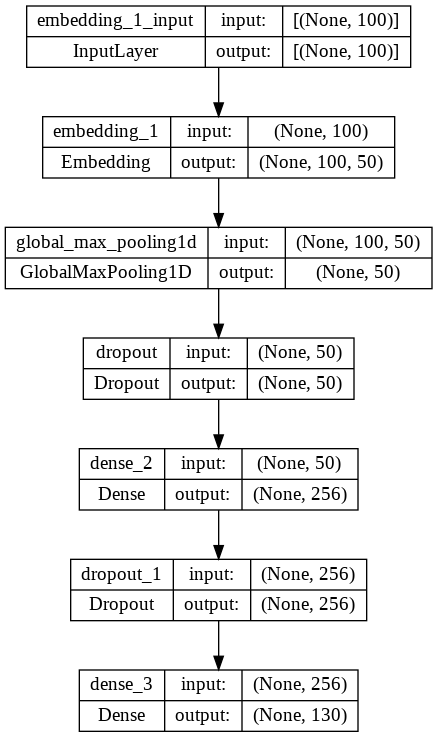

In [27]:
plot_model(model2, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [28]:
history_2 = model2.fit(X_train, y_train,
                       batch_size=32,
                       epochs=20,
                       validation_data=(X_val, y_val))

Epoch 1/20
10457/10457 [==============================] - 53s 5ms/step - loss: 1.7473 - accuracy: 0.5670 - f1_m: 0.5563 - val_loss: 1.1414 - val_accuracy: 0.6912 - val_f1_m: 0.6971
Epoch 2/20
10457/10457 [==============================] - 53s 5ms/step - loss: 1.2703 - accuracy: 0.6590 - f1_m: 0.6672 - val_loss: 1.0480 - val_accuracy: 0.7096 - val_f1_m: 0.7178
Epoch 3/20
10457/10457 [==============================] - 52s 5ms/step - loss: 1.2075 - accuracy: 0.6731 - f1_m: 0.6829 - val_loss: 1.0139 - val_accuracy: 0.7189 - val_f1_m: 0.7277
Epoch 4/20
10457/10457 [==============================] - 52s 5ms/step - loss: 1.1711 - accuracy: 0.6798 - f1_m: 0.6913 - val_loss: 0.9854 - val_accuracy: 0.7256 - val_f1_m: 0.7346
Epoch 5/20
10457/10457 [==============================] - 53s 5ms/step - loss: 1.1544 - accuracy: 0.6824 - f1_m: 0.6948 - val_loss: 0.9719 - val_accuracy: 0.7303 - val_f1_m: 0.7383
Epoch 6/20
10457/10457 [==============================] - 53s 5ms/step - loss: 1.1357 - accurac

NameError: ignored

In [30]:
embedding_dim = 50

model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model3.add(Conv1D(128, 10, activation='relu'))
model3.add(GlobalMaxPool1D())
model3.add(Dense(224, activation='tanh'))
model3.add(Dropout(0.5))
model3.add(Dense(130, activation='softmax'))
optimizer = keras.optimizers.Adam(lr=0.00005)
model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy',f1_m])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           3171550   
                                                                 
 conv1d (Conv1D)             (None, 91, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 224)               28896     
                                                                 
 dropout_2 (Dropout)         (None, 224)               0         
                                                                 
 dense_5 (Dense)             (None, 130)               29250     
                                                      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


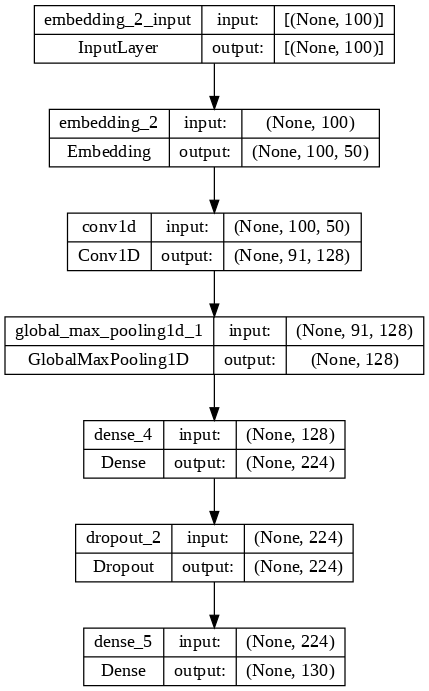

In [31]:
keras.utils.plot_model(model3, show_shapes=True, dpi=90)

In [32]:
history3 = model3.fit(X_train, y_train,
                       batch_size=32,
                       epochs=10,
                       validation_data=(X_val, y_val))

Epoch 1/10
10457/10457 [==============================] - 67s 6ms/step - loss: 1.4070 - accuracy: 0.6415 - f1_m: 0.6540 - val_loss: 1.0301 - val_accuracy: 0.7224 - val_f1_m: 0.7373
Epoch 2/10
10457/10457 [==============================] - 61s 6ms/step - loss: 1.0022 - accuracy: 0.7262 - f1_m: 0.7449 - val_loss: 0.9301 - val_accuracy: 0.7446 - val_f1_m: 0.7663
Epoch 3/10
10457/10457 [==============================] - 62s 6ms/step - loss: 0.9233 - accuracy: 0.7431 - f1_m: 0.7620 - val_loss: 0.8925 - val_accuracy: 0.7536 - val_f1_m: 0.7747
Epoch 4/10
10457/10457 [==============================] - 62s 6ms/step - loss: 0.8800 - accuracy: 0.7538 - f1_m: 0.7730 - val_loss: 0.8718 - val_accuracy: 0.7594 - val_f1_m: 0.7810
Epoch 5/10
10457/10457 [==============================] - 60s 6ms/step - loss: 0.8537 - accuracy: 0.7586 - f1_m: 0.7779 - val_loss: 0.8591 - val_accuracy: 0.7650 - val_f1_m: 0.7850
Epoch 6/10
10457/10457 [==============================] - 60s 6ms/step - loss: 0.8326 - accurac

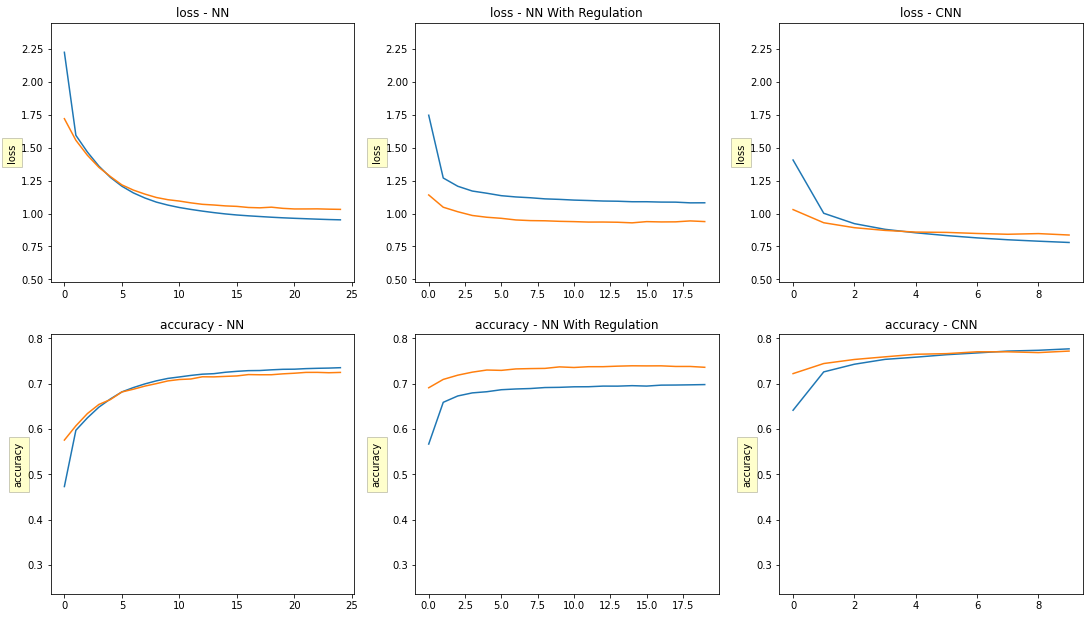

In [34]:
def make_plot(axs,
              model_history1, 
              model_history2,
              model_history3,
              model_1_name='NN',
              model_2_name='NN With Regulation',
              model_3_name='CNN'
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower3 = np.min(model_history3.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.5

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper3 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2, model_history3]):
            model_name = [model_1_name, model_2_name, model_3_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

fig, axs = plt.subplots(2, 3)

make_plot(axs,
          history1,
          history_2,
          history3,
          model_1_name='NN',
          model_2_name='NN With Regulation',
          model_3_name='CNN',
          )


fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()